In [33]:
from sklearn.cross_decomposition import PLSRegression
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [83]:
AssetReturnM = pd.read_excel('C:/Users/Thinkpad/Desktop/大类资产月度收益.xlsx').set_index('日期')/100
MacroIndicator = pd.read_excel('C:/Users/Thinkpad/Desktop/细分宏观指标.xlsx').set_index('日期').shift(1).dropna()

In [84]:
Y_cols = AssetReturnM.columns.tolist()
X_cols = MacroIndicator.columns.tolist()

In [85]:
MacroIndicatorForPredict = MacroIndicator.shift(1).dropna()
X_Y = MacroIndicatorForPredict.merge(AssetReturnM,left_index=True,right_index=True)

In [86]:
Y = X_Y[Y_cols]
X = X_Y[X_cols]

PLSRegression(copy=True, max_iter=500, n_components=9, scale=True, tol=1e-06)

In [ ]:
'''
偏最小二乘
'''

In [172]:
pls2 = PLSRegression(n_components=len(X_cols),scale=True)
pls2.fit(X, Y)

PLSRegression(copy=True, max_iter=500, n_components=9, scale=True, tol=1e-06)

In [173]:
# 原始数据对应PLS系数
pd.DataFrame(pls2.coef_,columns=Y_cols,index=X_cols)

,沪深300,中证全债,南华商品指数
工业增加值:当月同比,-0.002648,0.000691,-0.006208
CPI:当月同比,-0.029991,0.000529,0.001441
PPI:全部工业品:当月同比,-0.012861,0.001262,-0.008855
人民币:实际有效汇率指数,-0.035972,0.000669,-0.000756
M2:同比,-0.013960,-0.000668,-0.004224
PMI,-0.007894,-0.001451,0.003135
社会融资规模:当月值,-0.002589,-0.000863,-0.005686
银行间同业拆借:加权平均利率:1天:当月值,0.018545,-0.001265,0.007362
银行间同业拆借:加权平均利率:7天:当月值,-0.009452,0.000533,-0.019180


In [177]:
X_scale = X.copy()
for col in X.columns:
    X_scale[col] = (X_scale[col]-np.mean(X_scale[col]))/np.std(X_scale[col])
    
Y_scale = Y.copy()
for col in Y.columns:
    Y_scale[col] = (Y_scale[col]-np.mean(Y_scale[col]))/np.std(Y_scale[col])

In [178]:
pls2_s = PLSRegression(n_components=len(X_cols),scale=False)
pls2_s.fit(X_scale, Y_scale)

PLSRegression(copy=True, max_iter=500, n_components=9, scale=False, tol=1e-06)

In [179]:
# 标准化数据对应PLS系数
pd.DataFrame(pls2_s.coef_,columns=Y_cols,index=X_cols)

,沪深300,中证全债,南华商品指数
工业增加值:当月同比,-0.030014,0.082480,-0.136944
CPI:当月同比,-0.339951,0.063122,0.031777
PPI:全部工业品:当月同比,-0.145777,0.150765,-0.195321
人民币:实际有效汇率指数,-0.407750,0.079924,-0.016676
M2:同比,-0.158237,-0.079793,-0.093186
PMI,-0.089480,-0.173265,0.069147
社会融资规模:当月值,-0.029347,-0.103103,-0.125434
银行间同业拆借:加权平均利率:1天:当月值,0.210215,-0.151031,0.162393
银行间同业拆借:加权平均利率:7天:当月值,-0.107141,0.063601,-0.423081


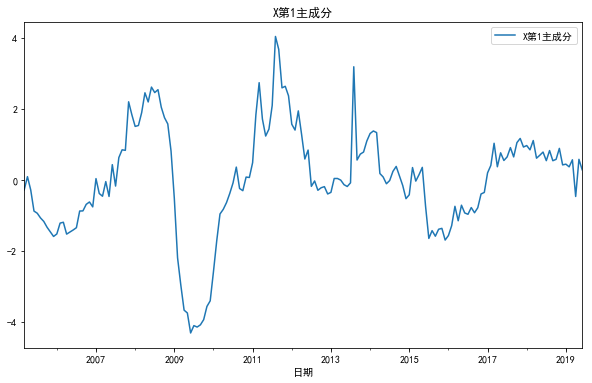

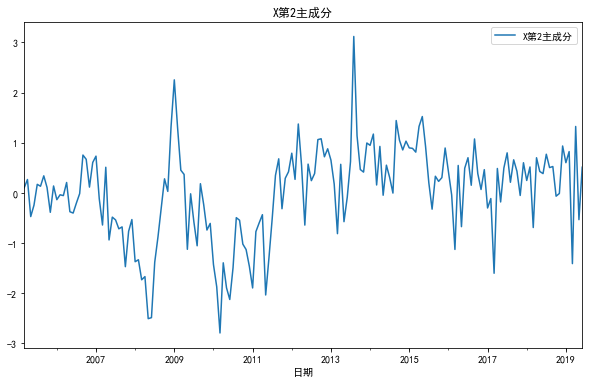

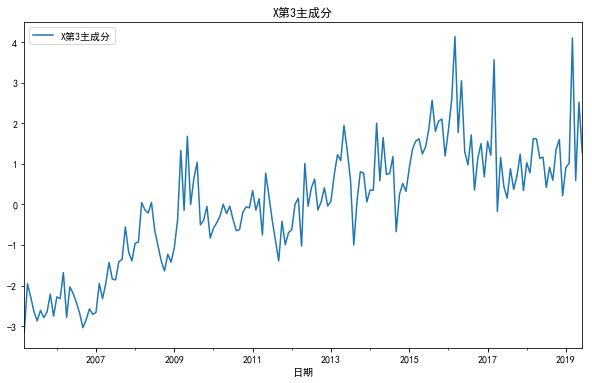

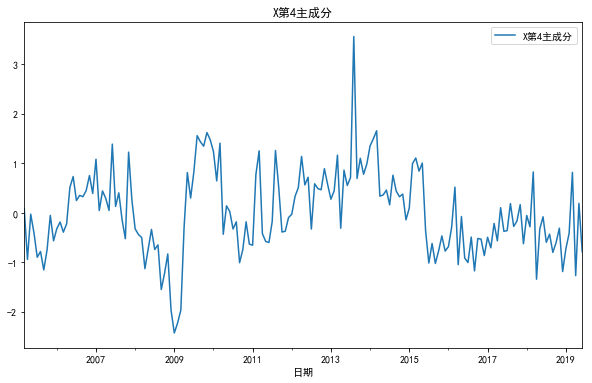

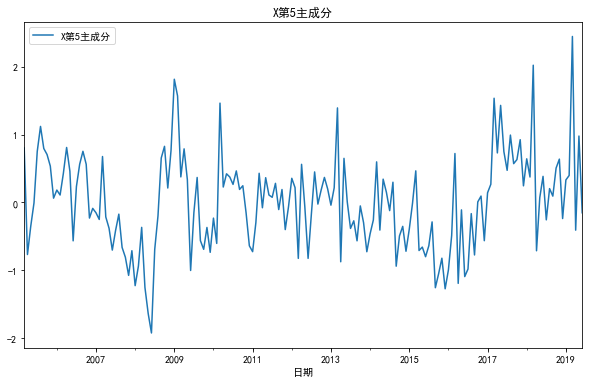

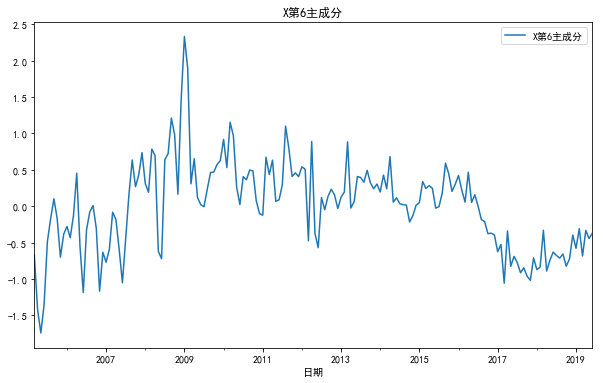

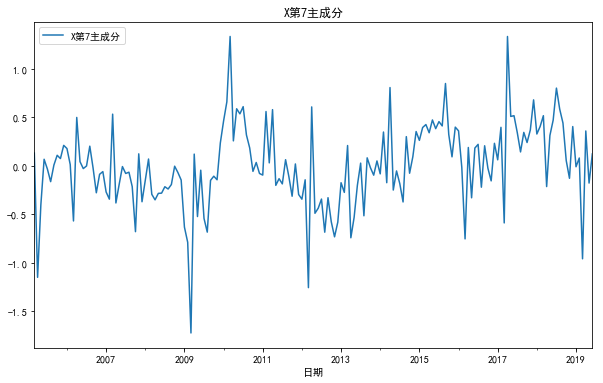

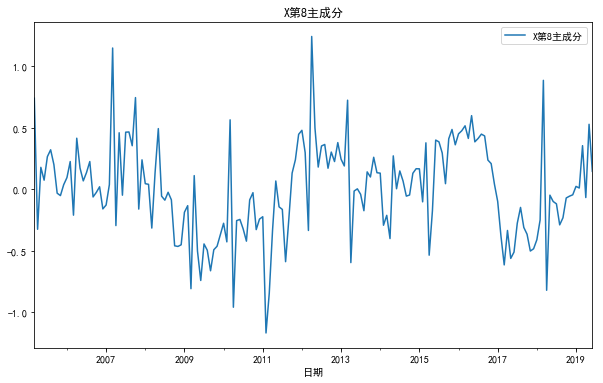

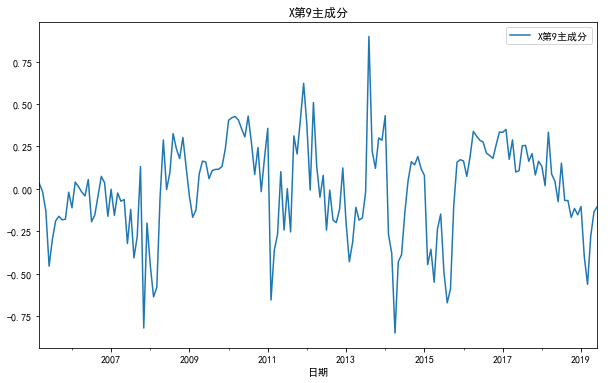

In [207]:
for i in range(len(X_cols)):
    pd.DataFrame(pls2.x_scores_[:,i],index=X.index,columns=['X第%d主成分'%(i+1)]).plot(figsize=(10,6),title='X第%d主成分'%(i+1))

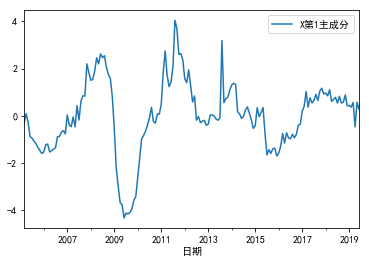

In [205]:
c_num = 0
ttt = pls2.x_weights_[:,c_num]
X_test = X_scale.copy()
for i in range(len(X_cols)):
    X_test[X_cols[i]] = X_test[X_cols[i]]*ttt[i]
X_test.sum(axis=1).to_frame('X第%d主成分'%(c_num+1)).plot()

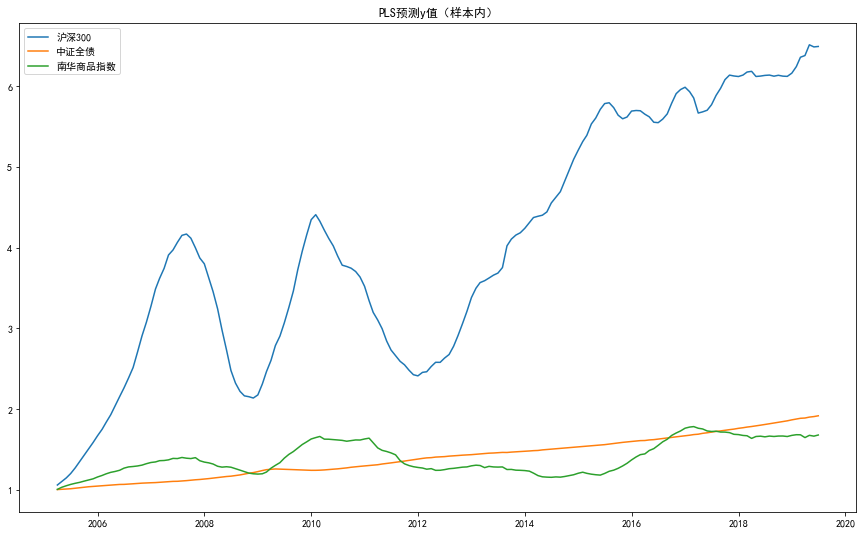

In [182]:
# PLS预测值（样本内）
Y_pred = pls2.predict(X)
plt.figure(figsize=(15,9))
Y_pred_df = (pd.DataFrame(Y_pred,columns=Y_cols,index=X_Y.index)+1).cumprod()
for col in Y_cols:
    plt.plot(Y_pred_df[col],label=col)
plt.title('PLS预测y值（样本内）')
plt.legend(loc=0)
plt.show()

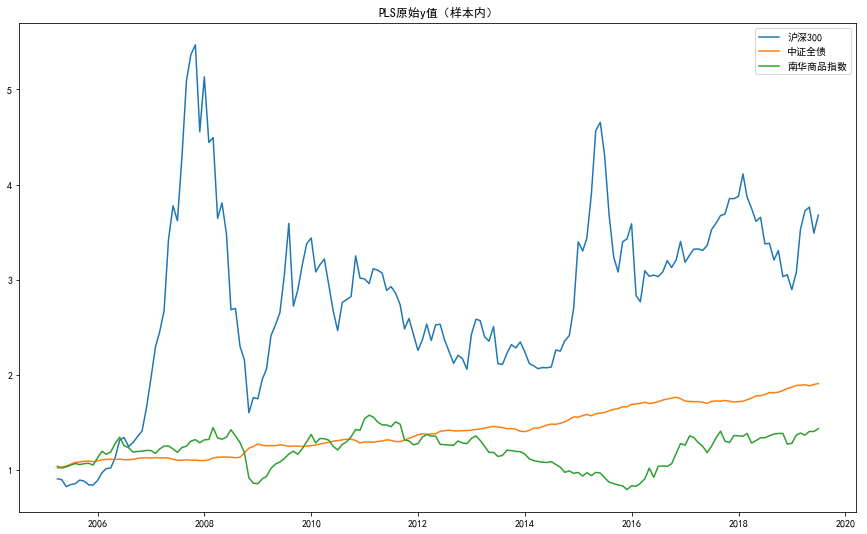

In [165]:
plt.figure(figsize=(15,9))
Y_df = (X_Y[Y_cols]+1).cumprod()
for col in Y_cols:
    plt.plot(Y_df[col],label=col)
plt.title('PLS原始y值（样本内）')
plt.legend(loc=0)
plt.show()

In [ ]:
'''
两步回归 多指标指标合成
'''

In [90]:
import numpy as np
def ComIndex(X, Z):
# Three Pass Regression Filter based on Kelly & Pruitt(2015)
# X is T * N array, predictors
# Z is T * M array, proxies,usually use Y as proxies
    if len(X.shape) == 1:
        X = np.reshape(X, (len(X), 1))
    if len(Z.shape) == 1:
        Z = np.reshape(Z, (len(Z), 1))

    T = Z.shape[0]
    N = X.shape[1]

    J_T = np.diag(np.ones(T)) - np.ones((T,T))/T
    J_N = np.diag(np.ones(N)) - np.ones((N, N))/N

    PHI = np.linalg.inv(Z.T.dot(J_T).dot(X).dot(J_N).dot(X.T).dot(J_T).dot(Z)).dot(Z.T).dot(J_T).dot(Z)
    F=X.dot(J_N).dot(X.T).dot(J_T).dot(Z).dot(PHI)

    return F

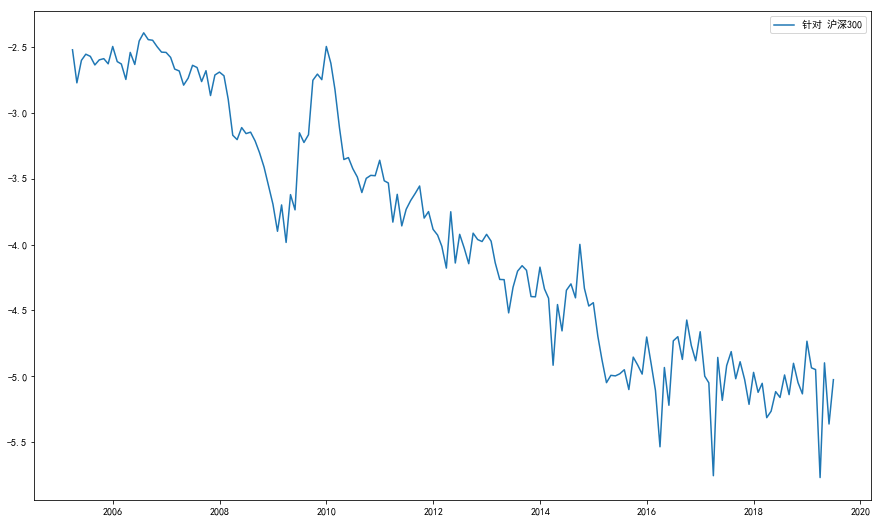

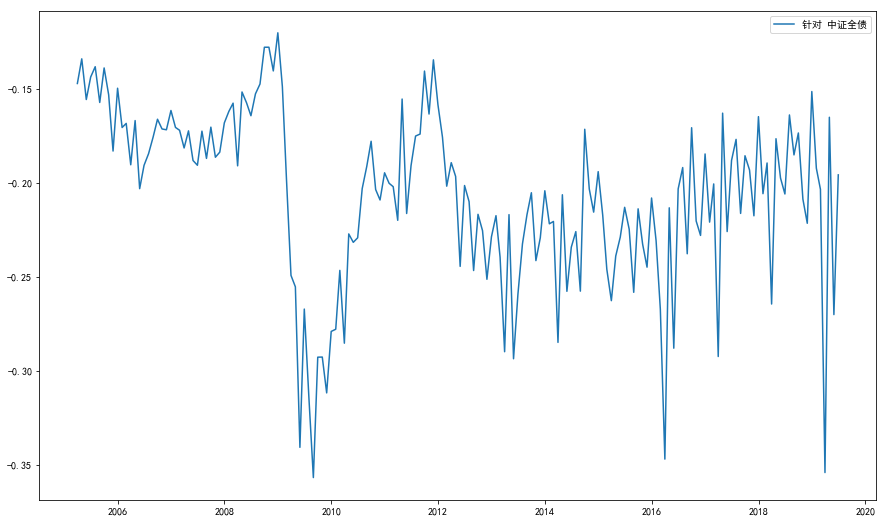

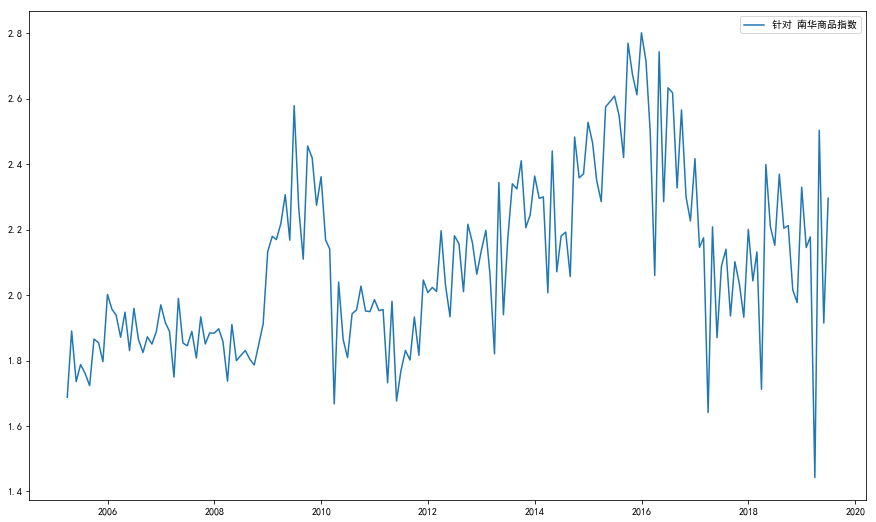

In [93]:
IndexDf = pd.DataFrame(ComIndex(np.matrix(X),np.matrix(Y)),columns=['针对 '+i for i in Y_df.columns],index=Y_df.index)
for col in IndexDf.columns:
    plt.figure(figsize=(15,9))
    plt.plot(IndexDf[col],label=col)
    plt.legend(loc=0)
    plt.show()